In [1]:
from __future__ import print_function
from __future__ import division

import os
import sys

import numpy as np

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt

from gPhoton.gFind import gFind
from gPhoton.gAperture import gAperture

from astropy.table import Table
from astropy import units as u
from astropy.io import fits,ascii

import matplotlib.pyplot as plt

from bisect import bisect_right

import analyseObject

sys.path.append('/Users/cbrasseur/Documents/FlareWork')

In [2]:
dataPath = '/Users/cbrasseur/Documents/FlareWork/data/'
galexLCPath = dataPath + 'flareFiles/galexLcs/'
keplerLCPath = dataPath + 'flareFiles/keplerLcs/'

<b>The numbers</b>

                          Final count of considered objects: 37,045
                 Number of first pass candidates for flares:  5,591
                     Number of candidates after second pass:  2,356
    Number of flaring stars after automatic flare detection:  1,960
      Number of flares found with automatic flare detection:  5,058
                          (ave. 2.6 flares per flaring star)
                                 (~5% of stars in set flare)
           Number of stars with flare energies calculations:  1,837
                           (depends on distance calculation)
                  Number of flares with calculated energies:  4,638

<b>Finding objects observed by both Kepler and GALEX.</b>

Objects observed by both GALEX and Kepler were found by using the <a href="http://iopscience.iop.org/0067-0049/211/1/2/suppdata/apjs489745t4_mrt.txt">Consolidated input values</a> table from Huber et al 2014,$^\ast$ crossmatched against the MAST <a href="https://archive.stsci.edu/pub/kepler/catalogs/README_KGMATCH">KGMatch</a> table, which lists objects found in both the Kepler Input Catalog and GALEX/GR6 (glx) catalog. 

Performing this crossmatch yielded the following results:

                          Number of Kepler targets:  196,468
                         Number of KGMatch entries:  379,031
    Number of objects targeted by Kepler and GALEX:   59,366
    
Next, gPhoton's gFind  command was used to extract observation times for each of the 59,366 objects targeted by both Kepler and GALEX. These observation times were used to determine which objects were observed simultaneously by Kepler and GALEX.

 The criterea for GALEX observations to be considered simultaneous with Kepler were:

   * Total observation time >= 30 minutes
   * Each individual observation >= 5 minutes
   * Observation times within the Kepler time range$^\dagger$  
   
The result of this operation was:

      GALEX observations that were too short:   6,998
       Simultaneous Kepler and GALEX targets:  37,225
    
Note: Due to the failure of GALEX's FUV camera in May 2009, all GALEX data simultaneous to Kepler observation is NUV.

<br><br>
$^\ast$ Huber, Daniel, Victor Silva Aguirre, Jaymie M. Matthews, Marc H. Pinsonneault, Eric Gaidos, Rafael A. García, Saskia Hekker et al. <a href="http://iopscience.iop.org/article/10.1088/0067-0049/211/1/2/meta;jsessionid=81E2939644C1C41C068FD790686D3737.c1">"Revised stellar properties of Kepler targets for the quarter 1-16 transit detection run."</a> The Astrophysical Journal Supplement Series 211, no. 1 (2014): 2. <br>
$^\dagger$ Kepler quarters were not considered as distinct, so this criterea does not actually guarentee truely simultaneous observations.

<b>Finding evidence of flaring in  GALEX objects</b>

gPhoton's gAperture command was used to extract light curves for the 37,225 simultaneous GALEX/Kepler targets. A first pass automatic flare detection algorithm was applied to these light curves and only those that showed evidence of flaring were saved. Light curves were extracted with 10 second binning, a radius of 0.004$^{\circ}$, and annulus from 0.005$^{\circ}$ - 0.007$^{\circ}$.  The radius and annulus were determined by looking at a selection of targets in ds9.

Light curves were determined to show evidence of flaring if the following critera were met:
  * Maximum count $\ge 3.5 \sigma$ above the mean 
  * At least one point directly adjacent to the maximum count bin $\ge 2 \sigma$ above the mean 

Of the 37,225 candidates this test was applied to, 5,591 showed evidence of flaring.

Upon manual examination of these 5,591 light curves, we determined that the first pass test was missing some key componants.  A second pass test was thus applied, where light curves were considered to show evidence of flaring if the following critera were met:
  * Maximum count $\ge 3.5 \sigma$ above the median 
  * At least one point directly adjacent to the maximum count bin $\ge 2 \sigma$ above the median 
  * Maximum count further from the median than minimum count
  
Changing the measurement from sigmas-from-mean to sigmas-from-median was implemented to better approximate the quiescent flux of the star. The requirement that the maximum be further from the median than the minimum guarded against light curves showing dips in magnitude rather than spikes being falsely marked as flaring objects.  

Of the 5,591 candidates the second-pass test was applied to, 2,356 showed evidence of flaring.
  

<b>Identifying flares in GALEX data</b>

At this point we turned from looking for evidence of flaring in a light curve, to detecting and marking actual flares. To this end automatic flare detection was applied to each light curve that had shown evidence of flaring.  The flare detection algorithm was as follows:
  * The light curve was split into "continuous sections," defined as sections for which consecutive time bins are no more than "maxGap" apart.  A maxGap of 1600s was used, which approximates the GALEX mission bookkeeping of "visits," and is the default maxgap for gPhoton.$^{\ast\ast}$
  * Within each continuous section, flare peaks were identified as points that rose $\geq3.5 \sigma$ above the median.  Flare edges were identified as the first points to either side that were $\leq$ the median (or the edge of the observation).
  * If the entire observation was identified as flaring, it was rejected as a spurious result.
  * The quiescent flux was also calculated by removing all the flares (as found above) and taking the mean of the remaining points.
  * If the calculated quiescent flux was zero, the light curve was rejected as suspect.$^\dagger$

Using this automatic flare detection, 5,058 flares were detected in 1,960 light curves.$^\ddagger$

<br><br>
$^{\ast\ast}$ See the <a href = "https://github.com/cmillion/gPhoton/blob/master/docs/UserGuide.md">gPhoton users guide</a><br>
$^\dagger$ This never happened, but there is a provision for it in the code.<br>
$^\ddagger$ Because there was no concept of continuous vs non-continuous observation in the algorithm for detecting flaring objects, some light curves were marked as flaring, but did not yield any flares with the automatic flare detection.

In [3]:
galexLCFiles = [galexLCPath + x for x in os.listdir(galexLCPath) if 'csv' in x]

In [4]:
galexFlareInfo = analyseObject.collectFlareInfo(galexLCFiles)
analyseObject.saveFlareStats(galexFlareInfo, dataPath + "galexFlareStats_automaticDetection.csv")
print("Number of detected flares:",len(galexFlareInfo))

Number of detected flares: 5058


In [4]:
galexFlareInfo = analyseObject.loadFlareStats(dataPath + "galexFlareStats_automaticDetection.csv")

<b>Calculating Various Statistics on the Body of Flares</b>

Some group calculations were made on this (obviously imperfect) set of 5,058 putative flares.

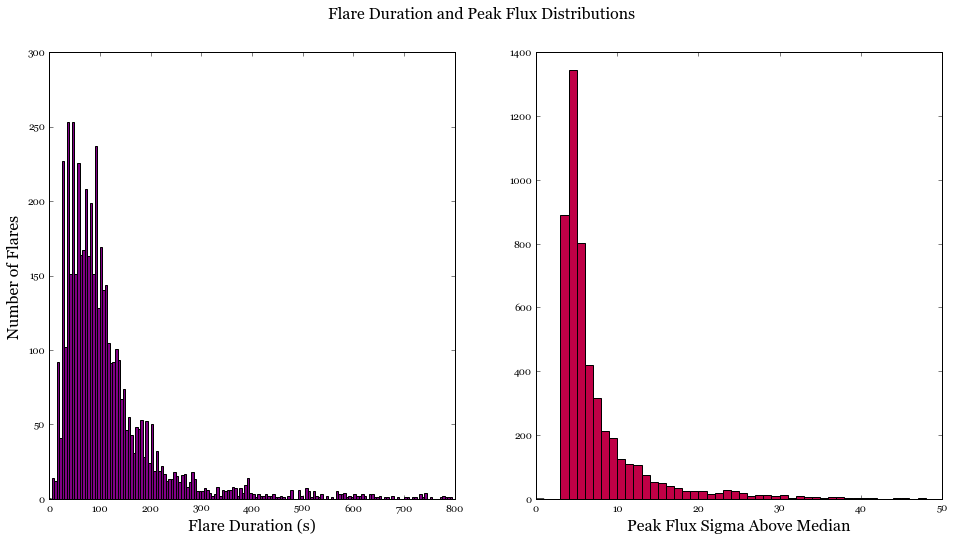

In [11]:
analyseObject.flareHistograms(galexFlareInfo, True)

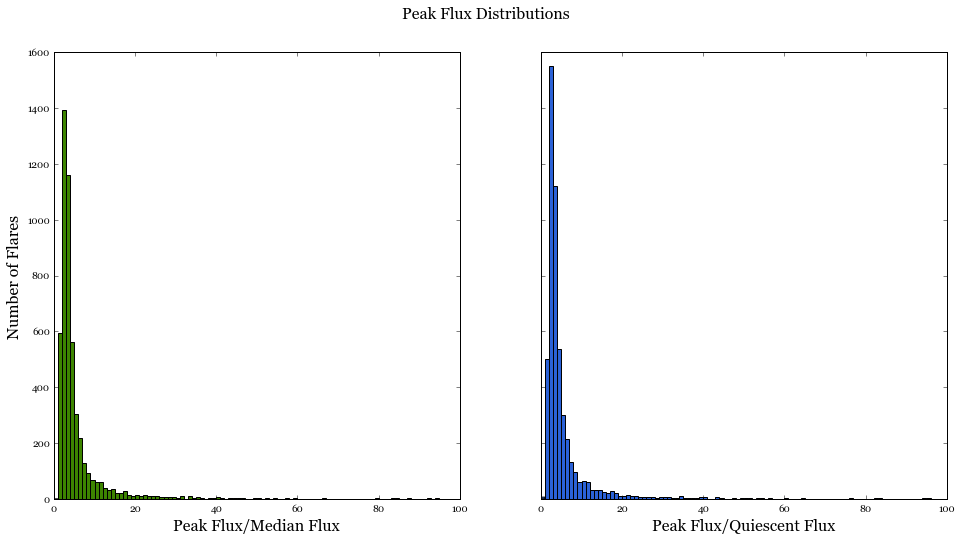

In [9]:
analyseObject.peakRatioHistograms(galexFlareInfo, True)

The flare duration histogram shows that the bulk of discovered flares are very short in duration, with 90% of them under 4 minutes, 94.5% under 5 minutes, and 98% under 9 minutes.  Looking at the Peak Flux Histogram, the bulk of the detected flares are between $3.5\sigma$ (the cuttoff for being considered a flare) and $6\sigma$. None are over $48\sigma$.

The two bottom plots show the distribution of Peak Flux to Quiescent Flux, where on the left the quiescent flux is taken to be the median, and on the right it is calculated by masking out the flares and averaging the remaining points. From manual inspection of some of the light curves with lowest peak flux/quiescent flux, it seems that some discrepencies between median flux and calculated quiescent flux are due to elevated fluxes with large errors that don't get flagged as flare events and thus contribute to the quiescent flux calculation.$^\ast$ Both histograms show that the bulk of the flares are smaller, with 50% of the peak to quiescent flux ratios being 3 or lower, and 90% 10 or lower.  Overall what we primarily see is a lot of short duration, not particularly high energy flares.

<br>
$^\ast$ I am unsure which measure of quescent flux is likely to be a better approximation, however in many of the more striking flaring light curves, they are essentially the same. In the calculations going forwards, the calculated quiescent flux is used rather than the median.

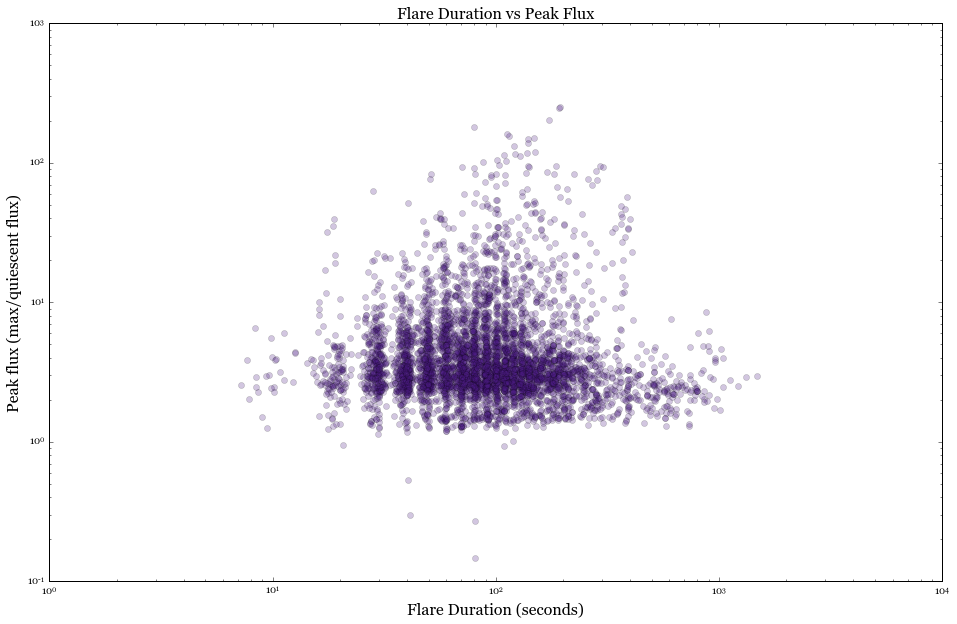

In [12]:
analyseObject.fluxVsDuration(galexFlareInfo)

This plot shows a number of outliers as well as a central glob where most of the flares fall.  There are slightly suspicious vertical lines apparent that are probably an artifact of the data, having to do with observation duration (for medium imaging survey ~26 minutes) and how flares overlap with that time. True flare duration is not extrapolated for cut off flares, so there is an artifical upper limit on detectable flare length in this dataset.

<b>Calculating Object Distances</b>

To explore the flare energy distribution, distances were needed for each flaring star. Information from several sources were combined to make distance calculations as outlined below.

The following information about every object listed in the <a href="https://archive.stsci.edu/pub/kepler/catalogs/README_KGMATCH">KGMatch</a> table was downloaded using the <a href="https://archive.stsci.edu/kepler/data_search/search.php">MAST Kepler Data Search and Retrieval</a> interface:$^\ast$  

        Kepler ID, RA (J2000), Dec (J2000), RA PM, Dec PM, Star/Gal ID, 
            Teff, Log G, Metallicity, E(B-V), A_V, Radius, Parallax

For stars with parallax measurements, calculating the distance is trivial, however for the rest of the stars, the calculation is more complex and involves more information than can be obtained from the MAST Kepler Database.

For stars without parallax measurements we used the distance modulus to calculate distance: 

$$d = 10^{0.2*(m - M + 5 - A)}$$

Where $d$ is distance in parsecs, $m$ and $M$ are the apparent and absolute magentudues of the star respectively, and $A$ is extinction. We calculated the distance using measurements for the V-band specifically.

The stellar parameters we needed for this calculation and their sources are given below:

| Parameter | Source |
| -------------------------------: | ----------------------- |
| Effective Temperature ($T_{eff}$): |<a href="https://archive.stsci.edu/search_fields.php?mission=kepler">MAST Kepler Database</a>|
| Stellar Radius ($R_{*/\odot}$): |<a href="https://archive.stsci.edu/search_fields.php?mission=kepler">MAST Kepler Database</a>|
| Derived A-V extinction ($A_v$): |<a href="https://archive.stsci.edu/search_fields.php?mission=kepler">MAST Kepler Database</a>|
| V-band Bolometric Correction ($BC_v$): |<a href="http://iopscience.iop.org/article/10.1088/0067-0049/208/1/9/meta">Pecaut et al, Table 5</a> $^\dagger$|
|V-Band Apparent Magnitude ($m_v$): |<a href="https://archive.stsci.edu/missions/hlsp/kplrubv/">EHK2012catalog.dat</a> $^\ddagger$|


Constant paramenters and sources are as follows:

| Parameter |Value| Source |
| -------------------------------: | :-------: | ----------------------- |
| Solar Radius ($R_\odot$): |695508000 m|<a href="http://docs.astropy.org/en/stable/constants/">astropy constants</a>|
| Solar Luminosity ($L_\odot$): |3.846e+26 W|<a href="http://docs.astropy.org/en/stable/constants/">astropy constants</a>|
| Stefan-Boltzmann constant ($\sigma$): |5.670373e-08 $W/K^4m^2$|<a href="http://docs.astropy.org/en/stable/constants/">astropy constants</a>|
| Absolute bolometric solar magnitude ($M_{bol_\odot}$): |4.74|<i>Introduction to Cosmology</i> p. 119$^{**}$|
 
Using these parameters the distance was calculated as follows:
$$ R_* = R_{*/\odot}  R_{\odot} $$<br>
$$L_* = 4 \pi \sigma  R_{*}^2  T_{eff}^4$$<br>
$$M_{bol_*} = M_{bol_\odot} - 2.5  log_{10}(L_{*}/L_\odot)$$<br>
$$M_v = M_{bol_*} - BC_v$$<br>
$$d = 10^{0.2(m_v - M_v + 5 - A_v)} $$<br>


<br><br>
$^\ast$  The superset of flaring objects was used, because at the time of calculation the final list of potentially flaring objects was not yet complete.<br>
$^\dagger$ Pecaut, Mark J., and Eric E. Mamajek. "Intrinsic colors, temperatures, and bolometric corrections of pre-main-sequence stars." The Astrophysical Journal Supplement Series 208, no. 1 (2013): 9.<br>
$^\ddagger$ Data in https://archive.stsci.edu/missions/hlsp/kplrubv/EHK2012catalog.dat, description of data file in EHK2012catalog.dat/hlsp_kplrubv_readme.txt.<br>
$^{**}$ Ryden, Barbara Sue. <i>Introduction to cosmology.</i> San Francisco USA: Addison-Wesley, 2003.

In [15]:
starDistances,nonStars = analyseObject.calculateDistances()
analyseObject.saveDistances(starDistances,dataPath + "calculatedStarDistances.csv")
print("Number of distances calculated:",len([x for x in starDistances if x[1] != None]))

Number of objects that are probably not stars: 0
Number of missing values:
{'A_V': 2396, 'Radius': 2396, 'Teff': 2396, 'm_v': 530}
Number of stars with parallax: 54
Number of distances calculated: 32689


In [16]:
starDistances = ascii.read(dataPath + "calculatedStarDistances.csv")

<b>Calculating Flare Energies</b>

Integrating under the curve of an individual flare (subtracting quiescent flux) gives an estimate of the energy released during the flare in the observed waveband.  This can be combined with an estimate of the percentage of energy in the observed waveband to total bolometric energy to estimate the total bolometric energy released during the flare.

Total bolometric flare energies were estimated by first calculating the fluence$^*$ for each detected flare, and then using the calculated distance to the star to translate fluence into energy.

Calculating fluence ($F$):
$$F = \sum\limits^t (f_t-f_{qui})EW_{galex}\Delta t$$

where $f_{qui}$ is the quiescent flux, $f_t$ is the flux in time bin t, $\Delta t$ is the width of time bin t, and $EW_{galex}$ is the width of the galex waveband in angstroms.$\dagger$

Calculating energy ($E$):
$$ E = 4 \pi d^2 F / p_{bol} $$

where $d$ is distance, and $p_{bol}$ is the percent of bolometric energy radiated in the Galex waveband.

We used the value $p_{bol} = 0.096$, calculated using information in Osten 2015.$^\ddagger$ 

<br>
$^*$The flux above quiescence integrated over the duration of the flare.<br>
$\dagger$ This is a crude estimate calculated using this <a href="http://www.baryons.org/ezgal/filters/galex_nuv">table</a> and this <a href="http://www.galex.caltech.edu/researcher/effective_area/EA-nuv.png">plot.</a>  It could be improved on.<br>
$\ddagger$Osten, Rachel A., and Scott J. Wolk. "Connecting flares and transient mass-loss events in magnetically active stars." The Astrophysical Journal 809, no. 1 (2015): 79.

In [19]:
flareEnergies = analyseObject.getEnergies(galexFlareInfo)
analyseObject.saveEnergies(flareEnergies,dataPath + "calculatedFlareEnergies.csv")
print("Number of stars for which flare energies can be calculated:",len(np.unique([x[0] for x in flareEnergies])))
print("Number of flares for which energies can be calculated:",len(flareEnergies))

Number of stars for which flare energies can be calculated: 1837
Number of flares for which energies can be calculated: 4638


In [22]:
flareEnergies = ascii.read(dataPath + "calculatedFlareEnergies.csv")

<b>Fitting Flare Energy Distribution Curve</b>

We expect the distribution of flare energies to follow a power law:
$$N(>E) = N_{tot}\left(\frac{E}{E_{min}}\right)^{1-\alpha}$$

We used the method described by <a href="http://arxiv.org/abs/0706.1062">Clauset et al</a>$^*$ to fit $\alpha$ and $E_{min}$ to our data:

$\alpha$ can be calculated as

$$\alpha = 1 + N_{tot}\left[\sum\limits_{i=1}^{N_{tot}}ln\left(\frac{E_i}{E_{min}}\right)\right]^{-1} $$

So $\alpha$ depends on $E_{min}$.  Per Clauset et al equation 3.9 we fit $E_{min}$ (and thus $\alpha$) by minimizing 

$$D = \max_{E \geq E_{min}}|S(E) - P(E)|$$

where $S(E)$ is the cumulative distribution function (CDF) of our data, and $P(E)$ is the CDF of the power law model for the given $E_{min}$.

$$S(E) = \frac{N(>E)}{N_{tot}}$$

$$P(E) = \left(\frac{E}{E_{min}}\right)^{1-\alpha}$$

<br>$^*$ Clauset, Aaron, Cosma Rohilla Shalizi, and Mark EJ Newman. "Power-law distributions in empirical data." SIAM review 51, no. 4 (2009): 661-703.

In [23]:
B,alpha,Emin = analyseObject.fitEnergyCurve(flareEnergies['Estimated Bolometric Energy (erg)'])

B 0.0366875152064
Emin 6.20304151546e+34
alpha 1.3349269333


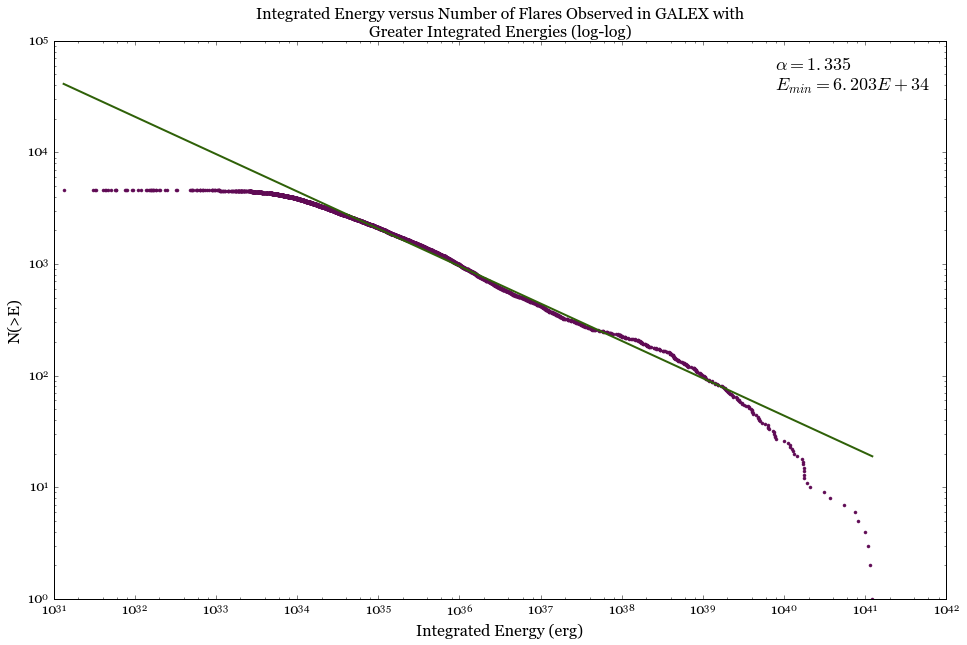

In [26]:
analyseObject.graphFitAndEnergies(Emin,alpha,flareEnergies['Estimated Bolometric Energy (erg)'])

An $\alpha$ value of ~1.3 is a bit lower than expected, but not outside the realm of possibility.  The above chart shows a nice flat middle section with both ends rolling away from the strict power law. At the upper end we are likely, at least to a certain extent, running into the limitations of our observations.  Higher energy flares are more likely to be longer, quite possibly longer than our observation time (flares that take up an entire observation period will not be detected since the flare detection algorithm used throws out intervals where the entire timeframe is a flare), so we will be under sampling high energy flares. On the lower end it is harder to differentiate flares from noise, and differences in how the quiescent flux is calculated is of greater importance.  Indeed a few flares show a calculated energy of zero due to the flare detection algorithm using median as quiescent flux and the energy claculation using the calculated quiescent flux (light curve mean after flares are masked out).

<b>Looking at Specific Light Curves</b>

Below is the light curve for GALEX 3153823897452807113 (Kepler 7431632).

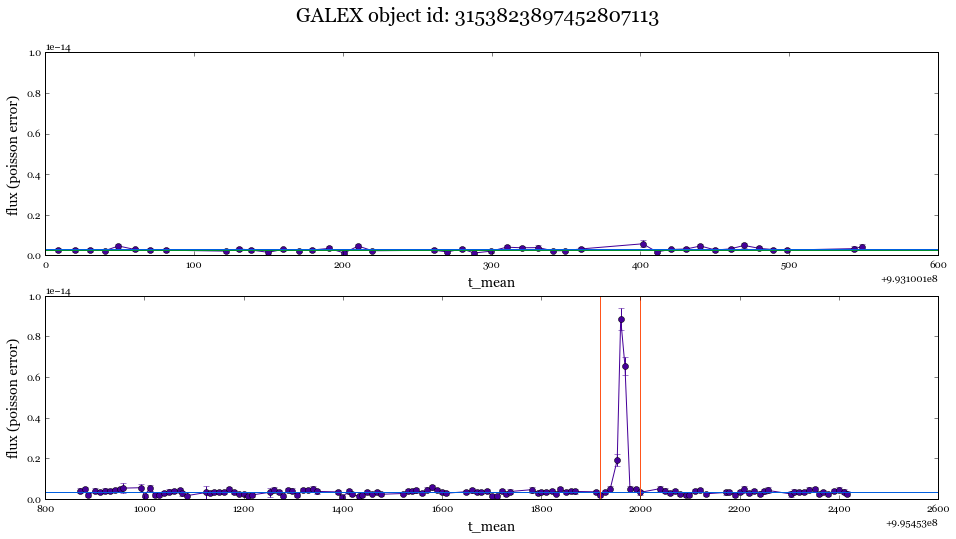

In [18]:
analyseObject.graphLightCurveFlux(galexLCPath + '3153823897452807113_LC.csv')

In the second interval a flare can be clearly seen.  Zooming in on that flare and resampling at a 1 second cadence with gPhoton gives the following plot:

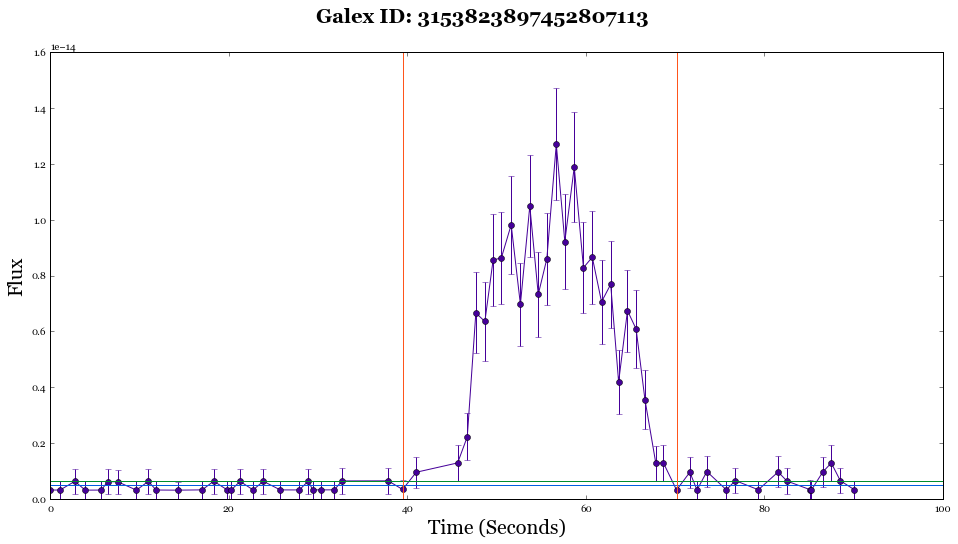

In [19]:
analyseObject.graphFlaresLC(dataPath + 'flareFiles/3153823897452807113_zoom2LC.csv', '3153823897452807113')

<b>Simultaneous Kepler Data</b>

Given the set of identified GALEX flares, the next step was to identify simultaneous Kepler data, and look for evidence of flaring in those light curves. At the beginning of this discussion it was noted that when looking for simultaneously observed objects Kepler quarters were not considered distinct.  The result is that truly simultaneous Kepler and GALAX data is a subset of the observations on which we have been working. A systematic exploration of what GALEX observations have corresponding Kepler light curves has not yet been completed, so there are no specific numbers as of yet.

There are some interesting simultaneous light curves nonetheless.  Below are two plots of Kepler 7959579 (which appears to map to two Galex IDs: 3190063800704304976 and 3190063800705362209).  The top plot shows two flares in the Galex data, with accompanying Kepler data. The second plot zooms in on the larger flare, and shows the heightened flux that appears in the same time bin in the Kepler data.

There are 2 intervals, which would you like to see? 2


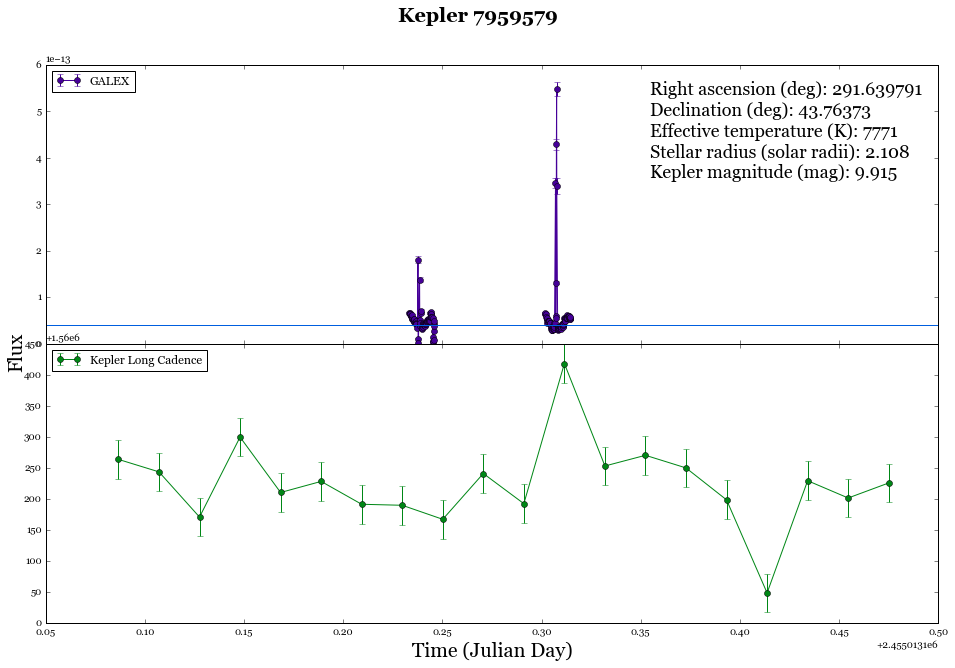

In [35]:
analyseObject.graphGalexAndKepler_inline('3190063800704304976',markFlares=False)

There are 3 intervals, which would you like to see? 3


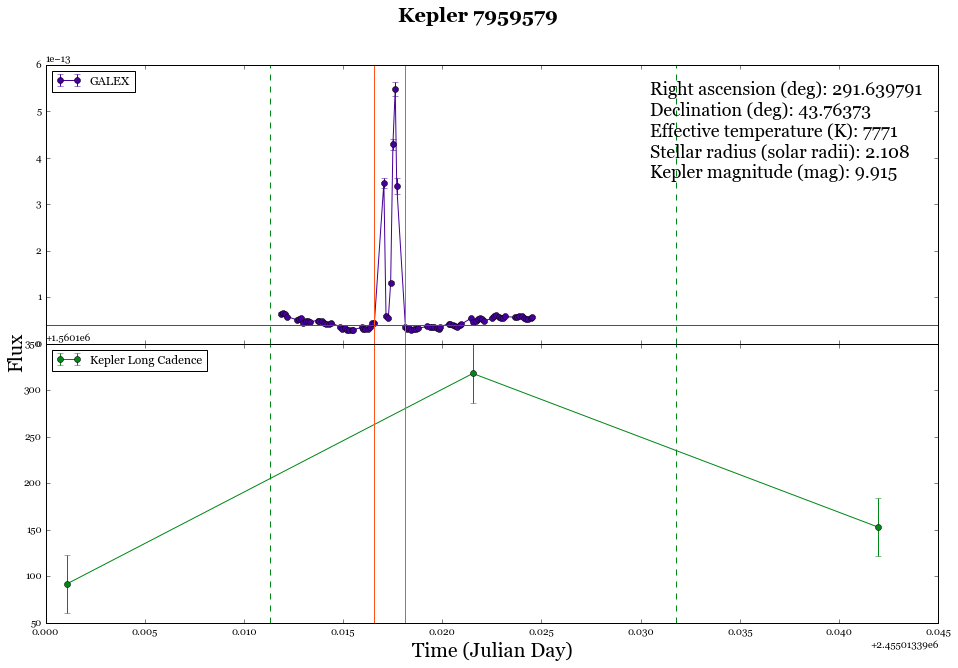

In [37]:
analyseObject.graphGalexAndKepler_inline('3190063800704304976',extraKepHours=1,markFlares=True,markKeplerBins=True)

In [25]:
reload(analyseObject)

<module 'analyseObject' from 'analyseObject.py'>